In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import e_pulses
from qspectro2d.visualization import plot_example_evo, plot_el_field, plot_all_pulse_components, plot_pulse_envelopes, plot_e_pulses
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.rwa_utils import get_expect_vals_with_RWA
from qspectro2d.config import create_base_sim_oqs

from plotstyle import init_style, COLORS, LINE_STYLES, save_fig
init_style()

from pathlib import Path
custom_dir = Path("test_Spectroscopy")
custom_dir.mkdir(exist_ok=True)

In [2]:
from typing import List, Optional, Tuple
from qspectro2d.spectroscopy import extend_time_domain_data
def compute_spectra(
    extended_datas: List[np.ndarray],
    signal_types: List[str] = ["rephasing"],
    t_det: np.ndarray = None,
    t_coh: Optional[np.ndarray] = None,
) -> Tuple[Optional[np.ndarray], np.ndarray, List[np.ndarray], List[str]]:
    # Detection axis frequency and wavenumber
    n_det = int(t_det.size)
    dt_det = t_det[1] - t_det[0]
    freq_dets = np.fft.fftfreq(n_det, d=dt_det)
    nu_dets = freq_dets / 2.998 * 10
    nu_dets = np.fft.fftshift(nu_dets)

    # Coherence axis frequency and wavenumber (optional)
    if t_coh is None:
        nu_cohs = None
    else:
        if t_coh.ndim != 1:
            raise ValueError("t_coh must be 1D when provided")
        n_coh = int(t_coh.size)
        dt_coh = t_coh[1] - t_coh[0]
        freq_cohs = np.fft.fftfreq(n_coh, d=dt_coh)
        nu_cohs = freq_cohs / 2.998 * 10
        nu_cohs = np.fft.fftshift(nu_cohs)

    # Build spectra
    datas_nu: List[np.ndarray] = []
    out_types: List[str] = []
    for idx, (arr, stype) in enumerate(zip(extended_datas, signal_types)):
        st_norm = str(stype).strip().lower()
        # Detection axis (+i) via IFFT along det axis
        spec_2d = np.fft.ifft(arr, axis=1)

        # Coherence axis sign depends on signal type
        if st_norm == "nonrephasing":
            spec_2d = np.fft.ifft(spec_2d, axis=0)
            out_types.append("nonrephasing")
        elif st_norm == "rephasing":
            spec_2d = np.fft.fft(spec_2d, axis=0)
            out_types.append("rephasing")
        else:
            spec_2d = np.fft.fft(spec_2d, axis=0)
            out_types.append(st_norm)

        spec_2d = np.fft.fftshift(spec_2d, axes=(0, 1))
        datas_nu.append(spec_2d)

    return nu_cohs, nu_dets, datas_nu, out_types

In [3]:
from qspectro2d.utils.constants import convert_cm_to_fs
# Parameters for the qubit system
omega0 = 16000      # transition frequency ~16000 cm⁻¹
omega0 = convert_cm_to_fs(omega0)  # convert to rad/fs
print(f"omega0 = {omega0:.2f} rad/fs")
Gamma = 0.01      # homogeneous dephasing rate = 1/100 fs⁻¹
Gamma1 = 1/300    # population decay rate = 1/300 fs⁻¹
t2 = 0.0          # waiting time (set to 0 for simplicity)

# Time grids for t_cohs and t_dets (coherence times)
dt = 0.1          # time step in fs
T_max = 300.0     # max time in fs
n_t = int(T_max / dt) + 1  # number of points
t_cohs = dt * np.arange(0, n_t)
t_dets = dt * np.arange(0, n_t)
T1, T3 = np.meshgrid(t_cohs, t_dets, indexing='ij')  # T1 is (n_t, n_t), etc.

# Individual response functions (time domain)
R1_time = np.exp(-1j * omega0 * T1 - Gamma * T1) * np.exp(-1j * omega0 * T3 - Gamma * T3) * np.exp(-Gamma1 * t2)
R2_time = np.exp(1j * omega0 * T1 - Gamma * T1) * np.exp(-1j * omega0 * T3 - Gamma * T3) * np.exp(-Gamma1 * t2)
R3_time = R2_time  # R3 = R2 for two-level system
R4_time = R1_time  # R4 = R1 for two-level system

# Combined for rephasing and non-rephasing
R_reph_time = R2_time + R3_time
R_nonr_time = R1_time + R4_time

omega0 = 3.01 rad/fs


In [4]:
# Extend time domain data for better FFT resolution
extended_datas, extended_t_det, extended_t_coh = extend_time_domain_data([R_reph_time, R_nonr_time], t_det=t_dets, t_coh=t_cohs, pad=4.0)
signal_types = ["rephasing", "nonrephasing"]

# Compute spectra using the compute_spectra function
nu_cohs, nu_dets, datas_nu, out_types = compute_spectra(extended_datas, signal_types, t_det=extended_t_det, t_coh=extended_t_coh)

print(f"Frequency axes: nu_cohs shape {nu_cohs.shape}, nu_dets shape {nu_dets.shape}")
print(f"Output types: {out_types}")
print(f"Spectra shapes: {[d.shape for d in datas_nu]}")

Frequency axes: nu_cohs shape (12004,), nu_dets shape (12004,)
Output types: ['rephasing', 'nonrephasing']
Spectra shapes: [(12004, 12004), (12004, 12004)]


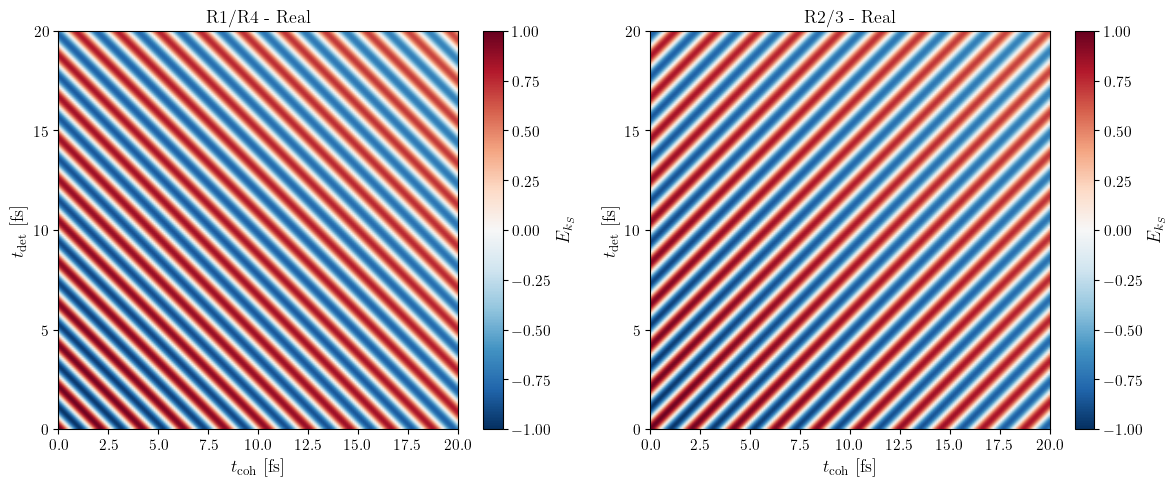

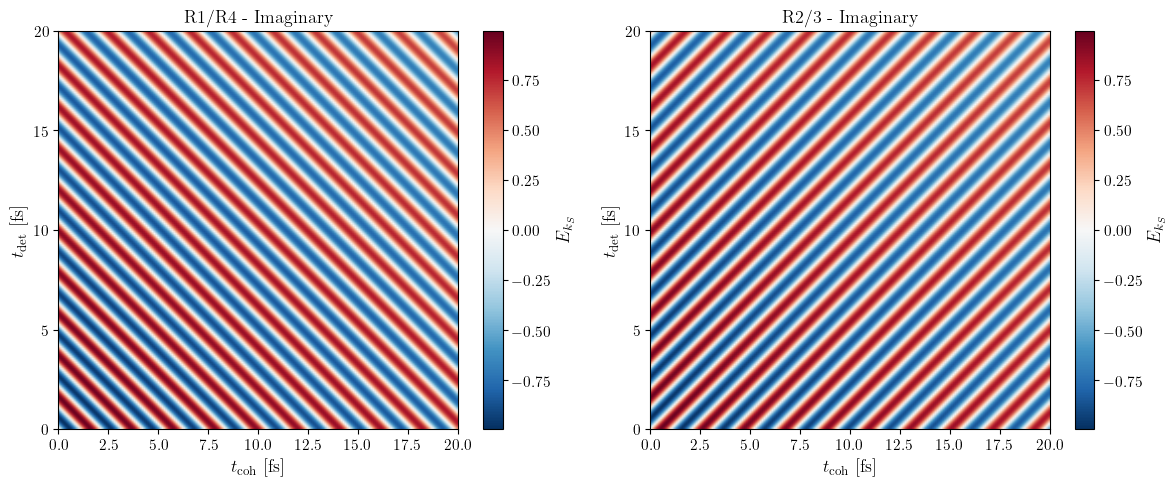

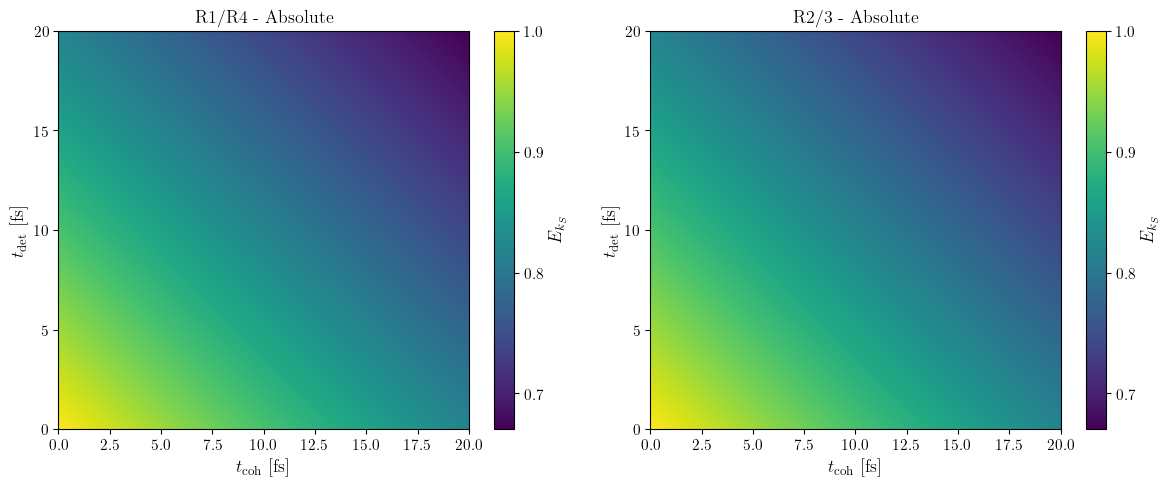

In [5]:
# Plot R1,R2 time domain - Real parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
responses_time = [R1_time, R2_time]
labels = ['R1/R4', 'R2/3']

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="real",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Real")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_real.png")
plt.show()

# Plot R1,R2 time domain - Imaginary parts (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="img",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Imaginary")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_img.png")
plt.show()

# Plot R1,R2 time domain - Absolute values (R3=R2, R4=R1)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (resp, label) in enumerate(zip(responses_time, labels)):
    ax = axes.flat[i]
    plot_el_field(
        axis_det=t_dets,
        data=resp,
        axis_coh=t_cohs,
        component="abs",
        domain="time",
        section=(0, 20),
        ax=ax
    )
    ax.set_title(f"{label} - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "R12_time_abs.png")
plt.show()

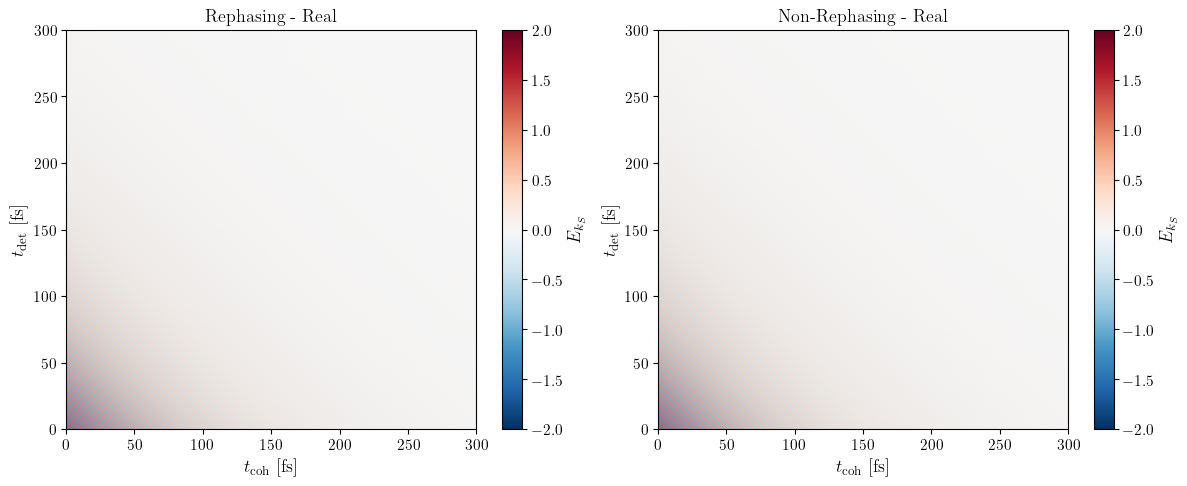

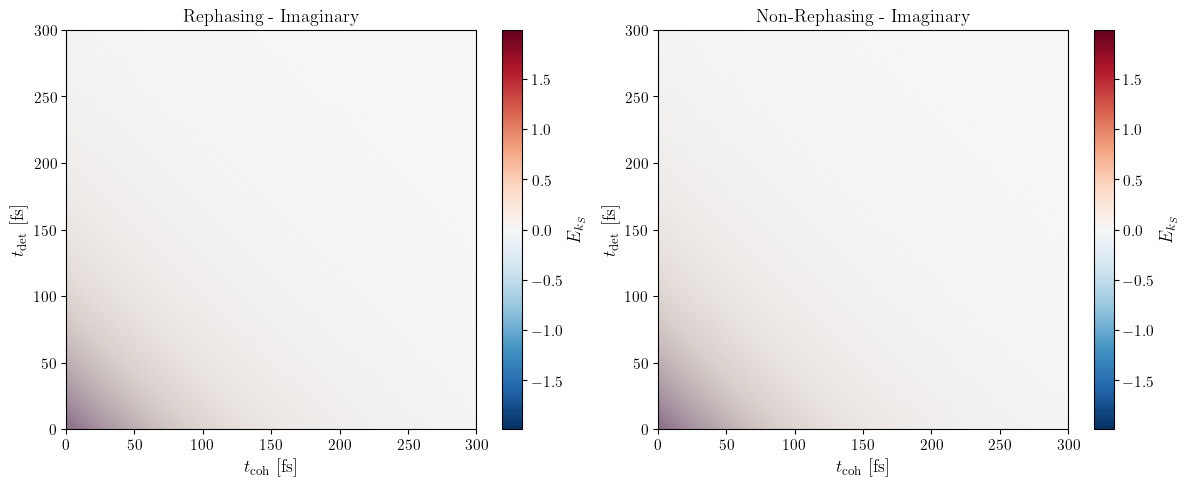

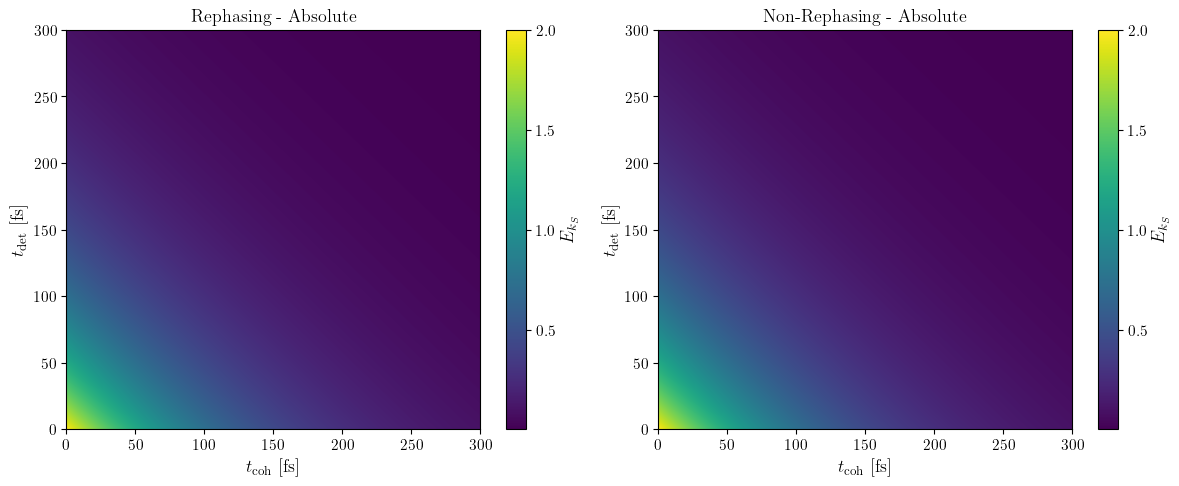

In [6]:
# Plot rephasing and non-rephasing time domain - Real parts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_el_field(
    axis_det=t_dets,
    data=R_reph_time,
    axis_coh=t_cohs,
    component="real",
    domain="time",
    ax=axes[0]
)
axes[0].set_title("Rephasing - Real")

plot_el_field(
    axis_det=t_dets,
    data=R_nonr_time,
    axis_coh=t_cohs,
    component="real",
    domain="time",
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Real")

plt.tight_layout()
save_fig(fig, custom_dir / "reph_nonreph_time_real.png")
plt.show()

# Plot rephasing and non-rephasing time domain - Imaginary parts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_el_field(
    axis_det=t_dets,
    data=R_reph_time,
    axis_coh=t_cohs,
    component="img",
    domain="time",
    ax=axes[0]
)
axes[0].set_title("Rephasing - Imaginary")

plot_el_field(
    axis_det=t_dets,
    data=R_nonr_time,
    axis_coh=t_cohs,
    component="img",
    domain="time",
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Imaginary")

plt.tight_layout()
save_fig(fig, custom_dir / "reph_nonreph_time_img.png")
plt.show()

# Plot rephasing and non-rephasing time domain - Absolute values
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_el_field(
    axis_det=t_dets,
    data=R_reph_time,
    axis_coh=t_cohs,
    component="abs",
    domain="time",
    ax=axes[0]
)
axes[0].set_title("Rephasing - Absolute")

plot_el_field(
    axis_det=t_dets,
    data=R_nonr_time,
    axis_coh=t_cohs,
    component="abs",
    domain="time",
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "reph_nonreph_time_abs.png")
plt.show()

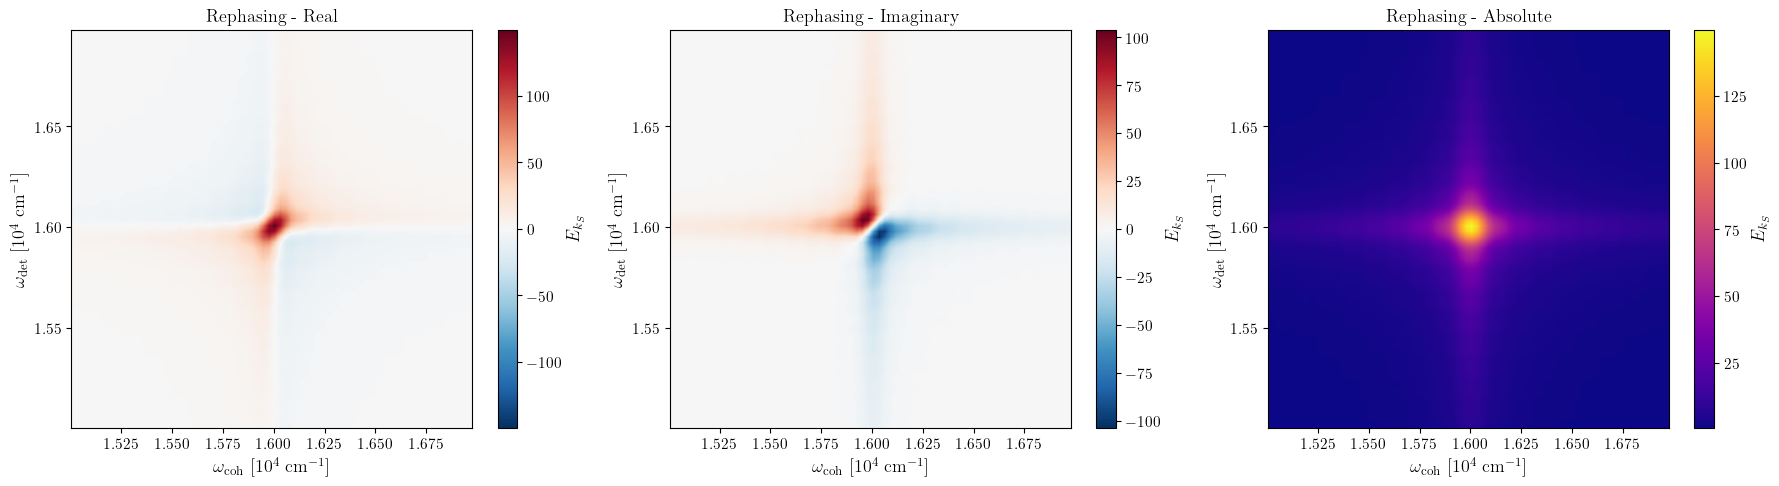

In [7]:
section = (1.5, 1.7)

# Plot rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[0],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "rephasing_spectra_combined.png")
plt.show()

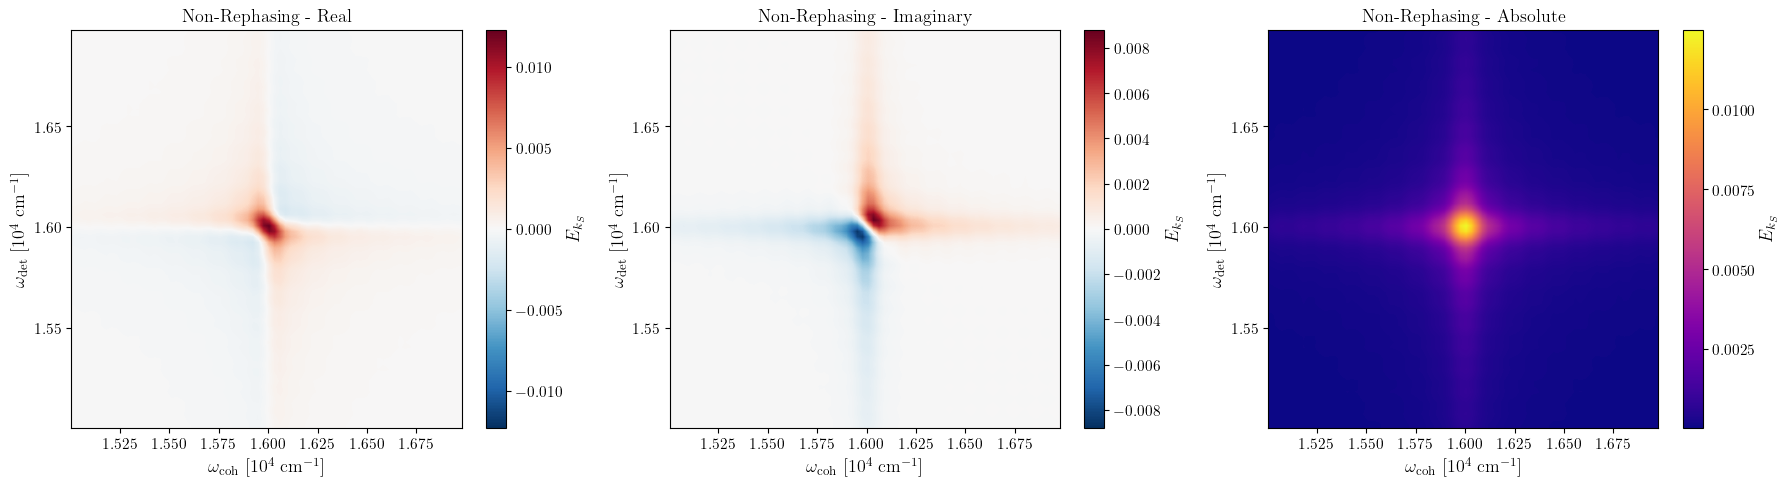

In [8]:
# Plot non-rephasing spectra in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Non-Rephasing - Real")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Non-Rephasing - Imaginary")

plot_el_field(
    axis_det=nu_dets,
    data=datas_nu[1],
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Non-Rephasing - Absolute")

plt.tight_layout()
save_fig(fig, custom_dir / "nonrephasing_spectra_combined.png")
plt.show()

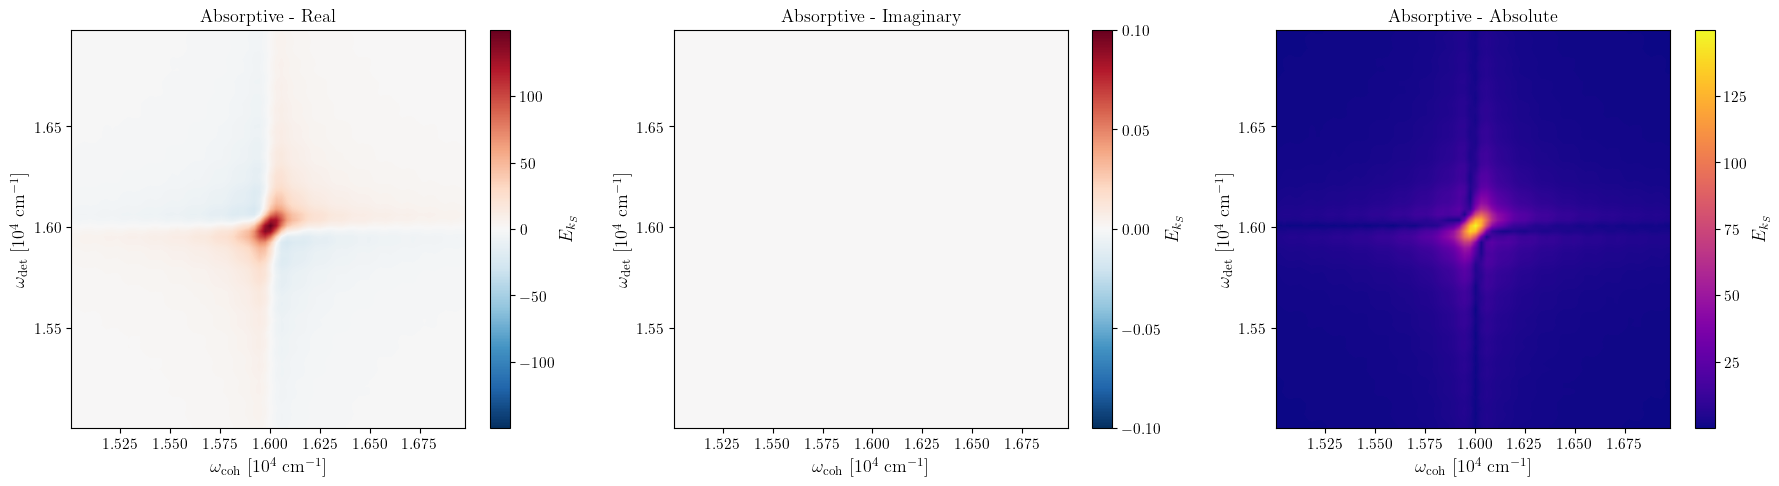

In [9]:
# Compute absorptive spectrum (complex sum)
absorptive = np.real(datas_nu[0] + datas_nu[1])

# Plot absorptive spectrum: real, imag, abs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="real",
    domain="freq",
    section=section,
    ax=axes[0]
)
axes[0].set_title("Absorptive - Real")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="img",
    domain="freq",
    section=section,
    ax=axes[1]
)
axes[1].set_title("Absorptive - Imaginary")
plot_el_field(
    axis_det=nu_dets,
    data=absorptive,
    axis_coh=nu_cohs,
    component="abs",
    domain="freq",
    section=section,
    ax=axes[2]
)
axes[2].set_title("Absorptive - Absolute")
plt.tight_layout()
save_fig(fig, custom_dir / "absorptive_section.png")
plt.show()